In [1]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from packages.DataProcessing import split_dataset
from packages.DataProcessing import tfrecords

plt.style.use('_mpl-gallery')

In [2]:
config = json.load(open("./conf/config.json"))

In [3]:
N_SPLITS = 5
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [4]:
# Data

df = pd.read_csv('./input/train_cultivar_mapping.csv')
df.dropna(inplace=True)

In [5]:
images = df['image'].to_numpy()
images = np.array(['./input/train_images/'+i for i in images])
images

array(['./input/train_images/2017-06-16__12-24-20-930.png',
       './input/train_images/2017-06-02__16-48-57-866.png',
       './input/train_images/2017-06-12__13-18-07-707.png', ...,
       './input/train_images/2017-06-28__10-20-32-417.png',
       './input/train_images/2017-06-28__12-47-02-714.png',
       './input/train_images/2017-06-04__13-12-56-053.png'], dtype='<U49')

In [6]:
num_images = len(images)
num_images

22193

In [7]:
cultivars = df['cultivar'].to_numpy()

In [8]:
class_names, counts = np.unique(cultivars, return_counts=True)
np.save("./output/class_names.npy", class_names)
num_classes = len(class_names)
num_classes

100

In [9]:
def get_onehot(label):
    one_hot = label == class_names
    return np.argmax(one_hot)

cultivars = np.array([get_onehot(cultivar) for cultivar in cultivars])
cultivars

array([73, 29, 99, ..., 18, 73, 58], dtype=int64)

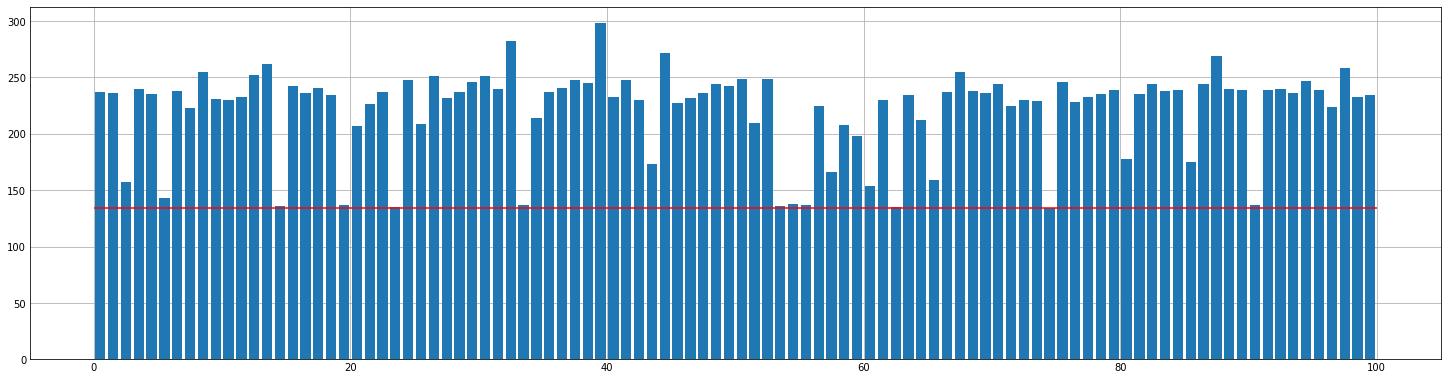

In [10]:
# EDA

plt.subplots(figsize=(20, 5))
plt.bar(np.arange(num_classes)+0.5, counts)
plt.hlines(counts.min(), 0, num_classes, colors='r')
plt.show()

In [11]:
df_test = pd.read_csv("./input/sample_submission.csv")

In [12]:
test_images = ["./input/test/" + filename for filename in df_test.filename]

In [13]:
# StratifiedKFold
ds_splits = split_dataset(images, cultivars, N_SPLITS=N_SPLITS)

train size: 17755
valid size: 4438


In [14]:
train_target = ds_splits['train'][1]
valid_target = ds_splits['valid'][1]
np.save("./output/train_target.npy", train_target)
np.save("./output/valid_target.npy", valid_target)

In [15]:
ds_splits['test'] = np.array(test_images)

In [16]:
os.mkdir(f"./output/tfrecords_{IMG_HEIGHT}_{IMG_WIDTH}")

In [17]:
# Writing TFRecords
records = tfrecords(IMG_HEIGHT, IMG_WIDTH)

records.WriteTFRecords(ds_splits, path=f'./output/tfrecords_{IMG_HEIGHT}_{IMG_WIDTH}')

100%|██████████| 23639/23639 [27:59<00:00, 14.08it/s] 


In [18]:
# Reading TFRecords
train_ds = records.get_dataset(f'./output/tfrecords_{IMG_HEIGHT}_{IMG_WIDTH}/train.tfrecords')
valid_ds = records.get_dataset(f'./output/tfrecords_{IMG_HEIGHT}_{IMG_WIDTH}/valid.tfrecords')
# test_ds = records.get_test_dataset(f'./output/tfrecords_{IMG_HEIGHT}_{IMG_WIDTH}/test.tfrecords')

In [19]:
BATCH_SIZE = 16
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()
# test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

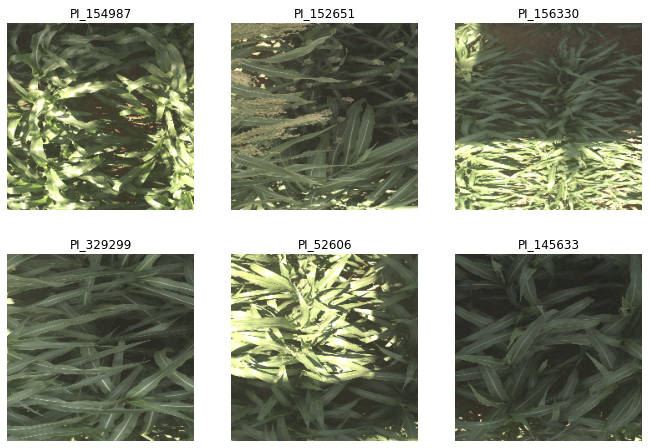

In [21]:
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(9, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image_batch[i].numpy().reshape(IMG_HEIGHT, IMG_WIDTH, 3))
    label = label_batch[i].numpy()
    plt.title(class_names[label])
    plt.axis("off")
plt.show()